In [66]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import pysal as ps
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights

import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import re

from sklearn.feature_extraction.text import CountVectorizer





/Users/mensab/Documents/GitHub/Artefact/artefactenv/lib/python3.11/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


SPATIAL ANALYSIS 

DIMENSIONALITY REDUCTION OF FEATURES 

DESIGN OF 
LABEL ENCODING FOR CATEGORY LABELS X
ONE HOT ENCODING FOR FEATURES 

The aim is to enable the removal of the classification labels and the creation of meaningful features to allow ML training

In [46]:
# Read in the data sites nw features
sites_nw_features = gpd.read_file('/Users/mensab/Documents/GISMapFiles/Files1600/sites_nw_features.shp')

sites_nw_features.columns
 

Index(['OID_', 'OBJECTID', 'ENTITY_ID', 'CLASS_CODE', 'SMRS', 'COUNTY',
       'TOWNLAND', 'COUNTY_ID', 'ZONE_ID', 'ITM_E', 'ITM_N', 'LATITUDE',
       'LONGITUDE', 'MONUMENT_T', 'FIRST_EDIT', 'LATEST_EDI', 'WEBSITE_LI',
       'WEB_NOTES', 'Boundary_I', 'Intersecti', 'geometry'],
      dtype='object')

In [58]:
# Load map 
tuatha_nw_1600_mod = gpd.read_file('/Users/mensab/Documents/GISMapFiles/Files1600/tuatha_nw_1600_mod.shp')

In [65]:
# Load soils data
soils_nw = gpd.read_file('/Users/mensab/Documents/GISMapFiles/Files1600/soils_map_nw.shp')

VARIOUS APPROACHES TO EXTRACT FEATURES FROM TEXT.
It is possible to extract feature data from text, but many entries do not have any data even to recover. Solutions will need another approach to recover scale data will be required. This can be automated. 

ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <function dimension_shape_ner at 0x134257c40> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [7]:
ef extract_entities(text):
    doc = nlp(text)
    entities = [{'text': ent.text, 'start': ent.start_char, 'end': ent.end_char, 'label': ent.label_}
                for ent in doc.ents]
    return entities

SyntaxError: invalid syntax (3896427257.py, line 1)

In [ ]:
df = pd.DataFrame({'WEB_NOTES': ["diam. 8m square", "circular shape 10m"]})
df['extracted_features'] = df['text_column'].apply(extract_entities)
print(df)

In [47]:
sites_nw_features['WEB_NOTES']

0       Marked only on the 1910 ed. of the OS 6-inch m...
1       Marked only on the 1910 ed. of the OS 6-inch m...
2       Marked only on the 1910 ed. of the OS 6-inch m...
3       Marked only on the 1910 ed. of the OS 6-inch m...
4       Davies (1948a, 115) recorded the site of a pla...
                              ...                        
9480    In pasture, on the level top of a low hill/dru...
9481    In good coastal grassland, 1km S of Ballysadar...
9482    In a rath (SL019-264001-), close to the NE arc...
9483    In rough, rush-grown upland pasture, located o...
9484    Reported by Jean-Charles Caillere; visible on ...
Name: WEB_NOTES, Length: 9485, dtype: object

In [48]:
# Initialize a CountVectorizer object
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))

# Fit and transform the WEB_NOTES column
X = vectorizer.fit_transform(sites_nw_features['WEB_NOTES'].values.astype('U'))

# Get the feature names (words or phrases)
feature_names = vectorizer.get_feature_names_out()

# Sum up the counts of each feature (word or phrase)
sum_words = X.sum(axis=0)

# Create a dictionary of words/phrases and their counts
words_freq = [(word, sum_words[0, idx]) for word, idx in zip(feature_names, list(range(X.shape[1])))]

# Sort the words/phrases by their counts
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Print the 25 most common words/phrases
for word, freq in words_freq[:20]:
    print(word, freq)

bank 4731
area 4719
int 3927
circular 3906
diam 3599
wth 3577
5m 2904
circular area 2825
enclosed 2644
earthen 2627
pasture 2615
raised 2475
fosse 2452
situated 2363
stone 2224
earthen bank 2208
slope 2132
facing 2094
se 2059
ne 2015


In [49]:


# Add "two", "subrectangular", and "subcircular" to the list of common words
common_words = [word for word, freq in words_freq[:20]] + ['single banked','double banked','triple banked','univallate','bivallate', 'trivallate', 'square', 'round', 'oval', 'subrectangular', 'suboval','subcircular']

def extract_words(text):
    words = []
    for word in common_words:
        if word in text:
            words.append(word)
    # Modify the regular expression to capture the diameter information within the brackets
    diam_matches = re.findall(r'\((int\. )?diam\. c\. (\d+(\.\d+)?)m\)', text)
    for match in diam_matches:
        words.append('diam. c. ' + match[1] + 'm')
    return words

sites_nw_features['extracted_words'] = sites_nw_features['WEB_NOTES'].apply(extract_words)

In [50]:
# view the extracted words
sites_nw_features['extracted_words']


0                                                    [ne]
1                                                    [ne]
2                                               [int, ne]
3                                                [se, ne]
4                                         [stone, se, ne]
                              ...                        
9480                                     [pasture, round]
9481                        [stone, slope, se, ne, round]
9482                           [bank, int, stone, se, ne]
9483                                 [pasture, slope, se]
9484    [area, circular, diam, 5m, circular area, foss...
Name: extracted_words, Length: 9485, dtype: object

In [51]:
# Write the 'extracted_words' column to a CSV file
sites_nw_features['extracted_words'].to_csv('extracted_words.csv', index=False)



In [26]:
sites_nw_features['WEB_NOTES'].to_csv('web_notes.csv', index=False)

In [52]:
# Create a new column called DIAMETER that contains the diameter information

def extract_diameter(text):
    # Search for diameter information within the brackets
    diam_match = re.search(r'\((int\. )?diam\. c\. (\d+(\.\d+)?)m\)', text)
    if diam_match:
        # If found, return the diameter value
        return 'diam. c. ' + diam_match.group(2) + 'm'
    else:
        # If not found, return a placeholder value
        return 'No Diameter Info'

# Create the DIAMETER column
sites_nw_features['DIAMETER'] = sites_nw_features['WEB_NOTES'].apply(extract_diameter)


A Sample of Entries is here dealt with where Diameter information could be recovered
It may be a future project to further analyse these using a trained AI to extract phrases.
Another approach is to use satellite and Lidar surveys to locate and recover measurements directly, as many entries do not have any even within the text. 

The random nature of the subset of data means its of limited use for real archaeological analysis. 


In [54]:
# Filter the DataFrame for 'Ringfort - raths' entries
raths = sites_nw_features[sites_nw_features['MONUMENT_T'] == 'Ringfort - rath']

# Count the number of 'Ringfort - raths' entries that have diameter information
num_raths_with_diameter = raths[raths['DIAMETER'] != 'No Diameter Info'].shape[0]

# Count the total number of 'Ringfort - raths' entries
total_raths = raths.shape[0]

print(f"Number of 'Ringfort - raths' entries with diameter information: {num_raths_with_diameter}")
print(f"Total number of 'Ringfort - raths' entries: {total_raths}")


Number of 'Ringfort - raths' entries with diameter information: 656
Total number of 'Ringfort - raths' entries: 3961


In [75]:
# Filter the DataFrame for 'Ringfort - raths' entries
cashels = sites_nw_features[sites_nw_features['MONUMENT_T'] == 'Ringfort - cashel']

# Count the number of 'Ringfort - raths' entries that have diameter information
num_cashels_with_diameter = cashels[cashels['DIAMETER'] != 'No Diameter Info'].shape[0]

# Count the total number of 'Ringfort - raths' entries
total_cashels = cashels.shape[0]

print(f"Number of 'Ringfort - cashels' entries with diameter information: {num_cashels_with_diameter}")
print(f"Total number of 'Ringfort - cashels' entries: {total_cashels}")


Number of 'Ringfort - cashels' entries with diameter information: 53
Total number of 'Ringfort - cashels' entries: 811


/Users/mensab/Documents/GitHub/Artefact/artefactenv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mensab/Documents/GitHub/Artefact/artefactenv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


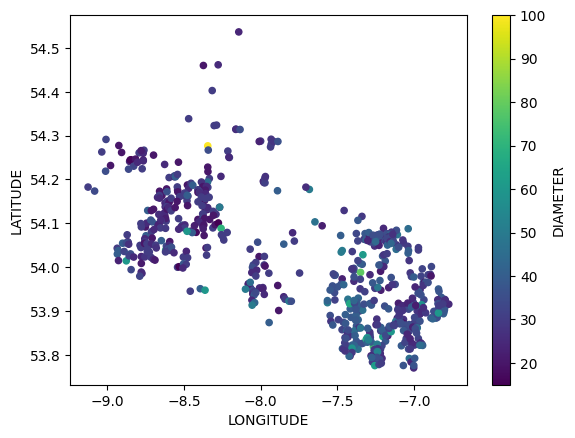

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

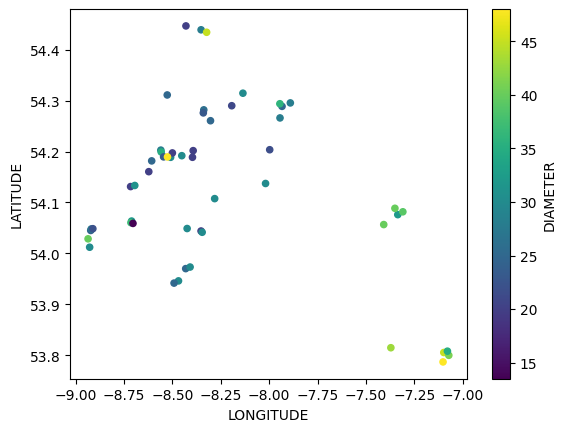

In [76]:
# Filter the DataFrame for 'Ringfort - raths' entries that have diameter information
raths_with_diameter = raths[raths['DIAMETER'] != 'No Diameter Info']
cashels_with_diameter = cashels[cashels['DIAMETER'] != 'No Diameter Info']

# Extract the numerical part of the diameter information and convert it to an integer
raths_with_diameter['DIAMETER'] = raths_with_diameter['DIAMETER'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
cashels_with_diameter['DIAMETER'] = cashels_with_diameter['DIAMETER'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# Drop any rows with non-numeric diameter information
raths_with_diameter = raths_with_diameter.dropna(subset=['DIAMETER'])
cashels_with_diameter = cashels_with_diameter.dropna(subset=['DIAMETER'])

# Plot the 'Ringfort - raths' entries
raths_with_diameter.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='DIAMETER', colormap='viridis')
plt.show()
cashels_with_diameter.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='DIAMETER', colormap='viridis')


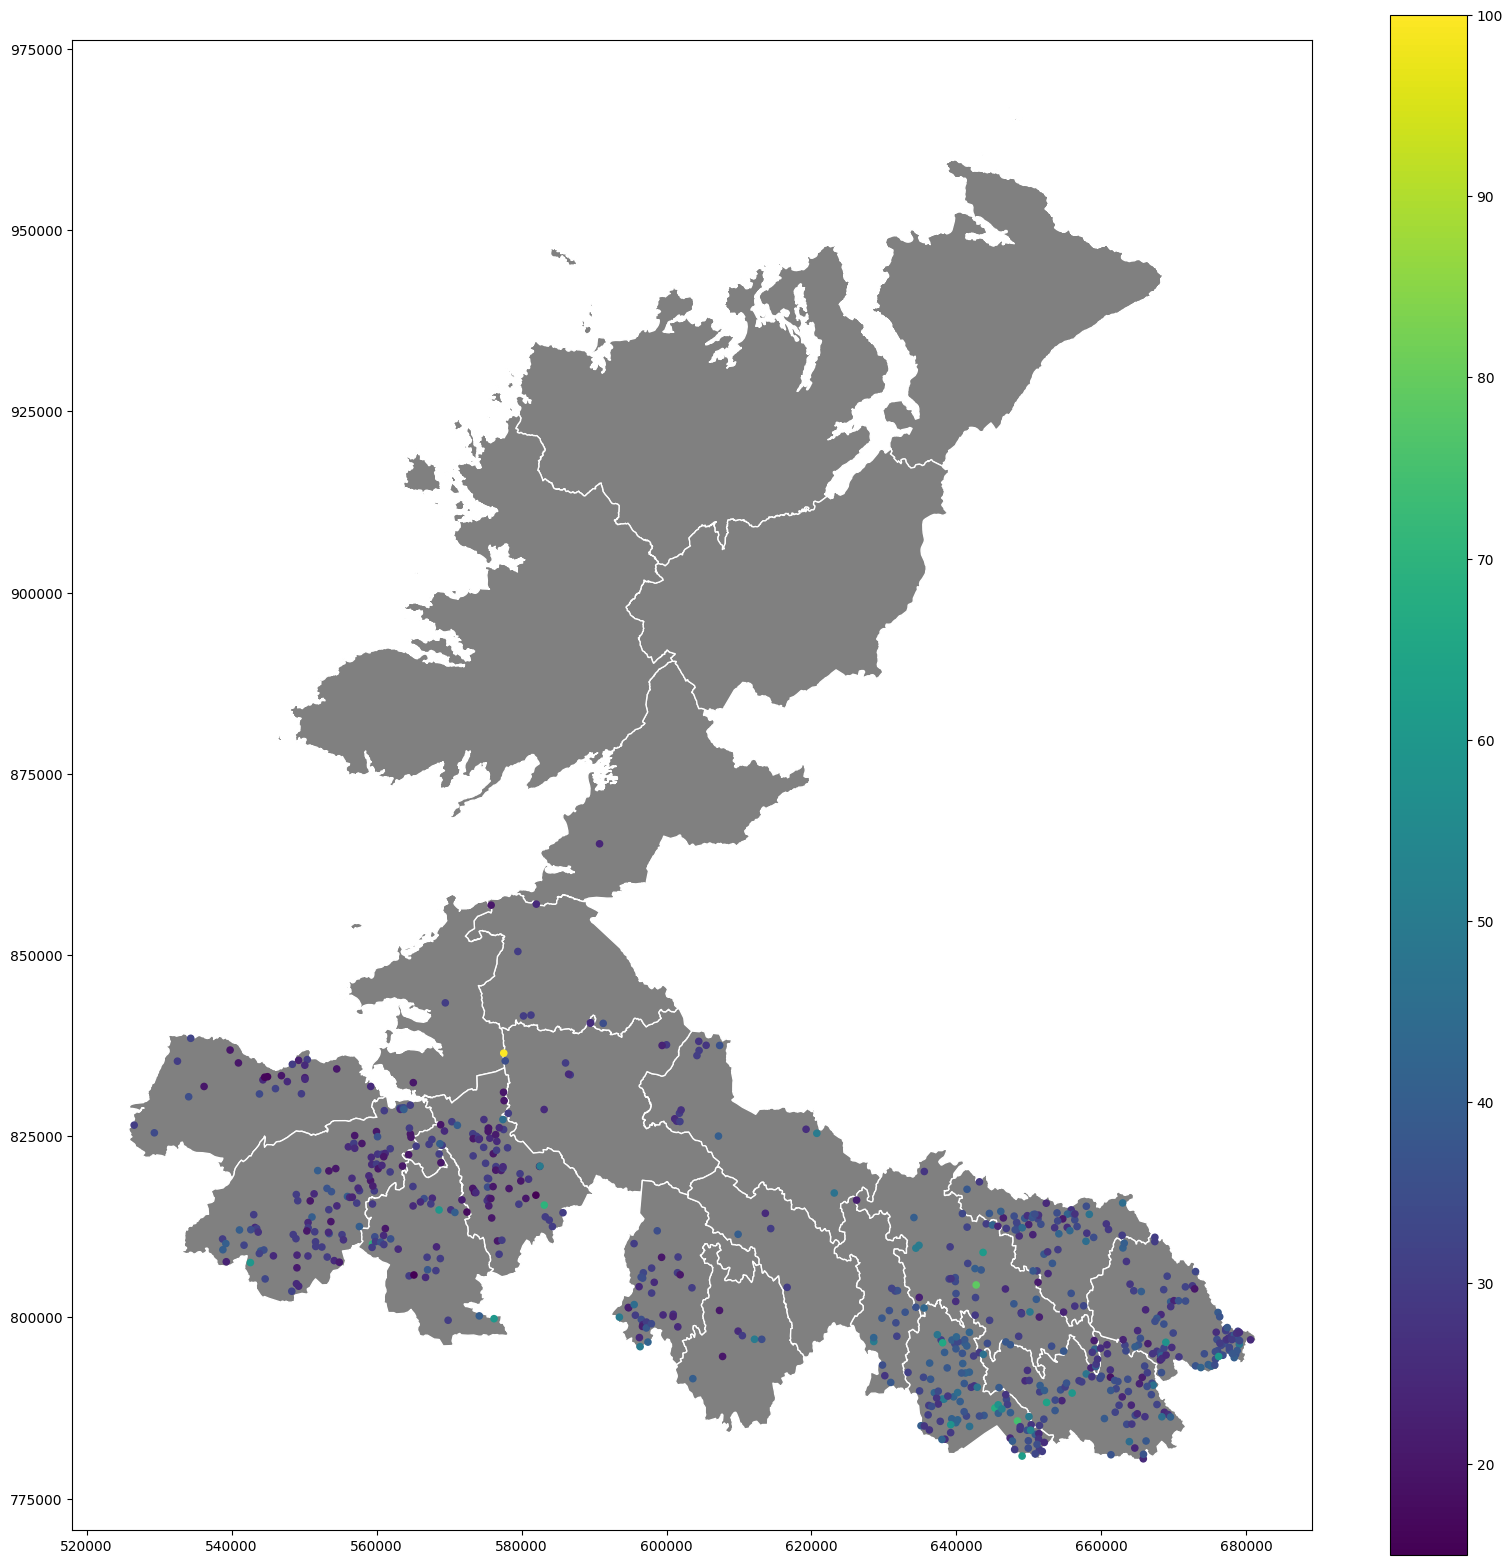

In [63]:
# Plot the Raths with diameter information on a map by size of diameter
fig, ax = plt.subplots(figsize=(20, 20))
tuatha_nw_1600_mod.plot(ax=ax, color='grey', edgecolor='white')
raths_with_diameter.plot(ax=ax, column='DIAMETER', legend=True, cmap='viridis', markersize=20)
plt.show()


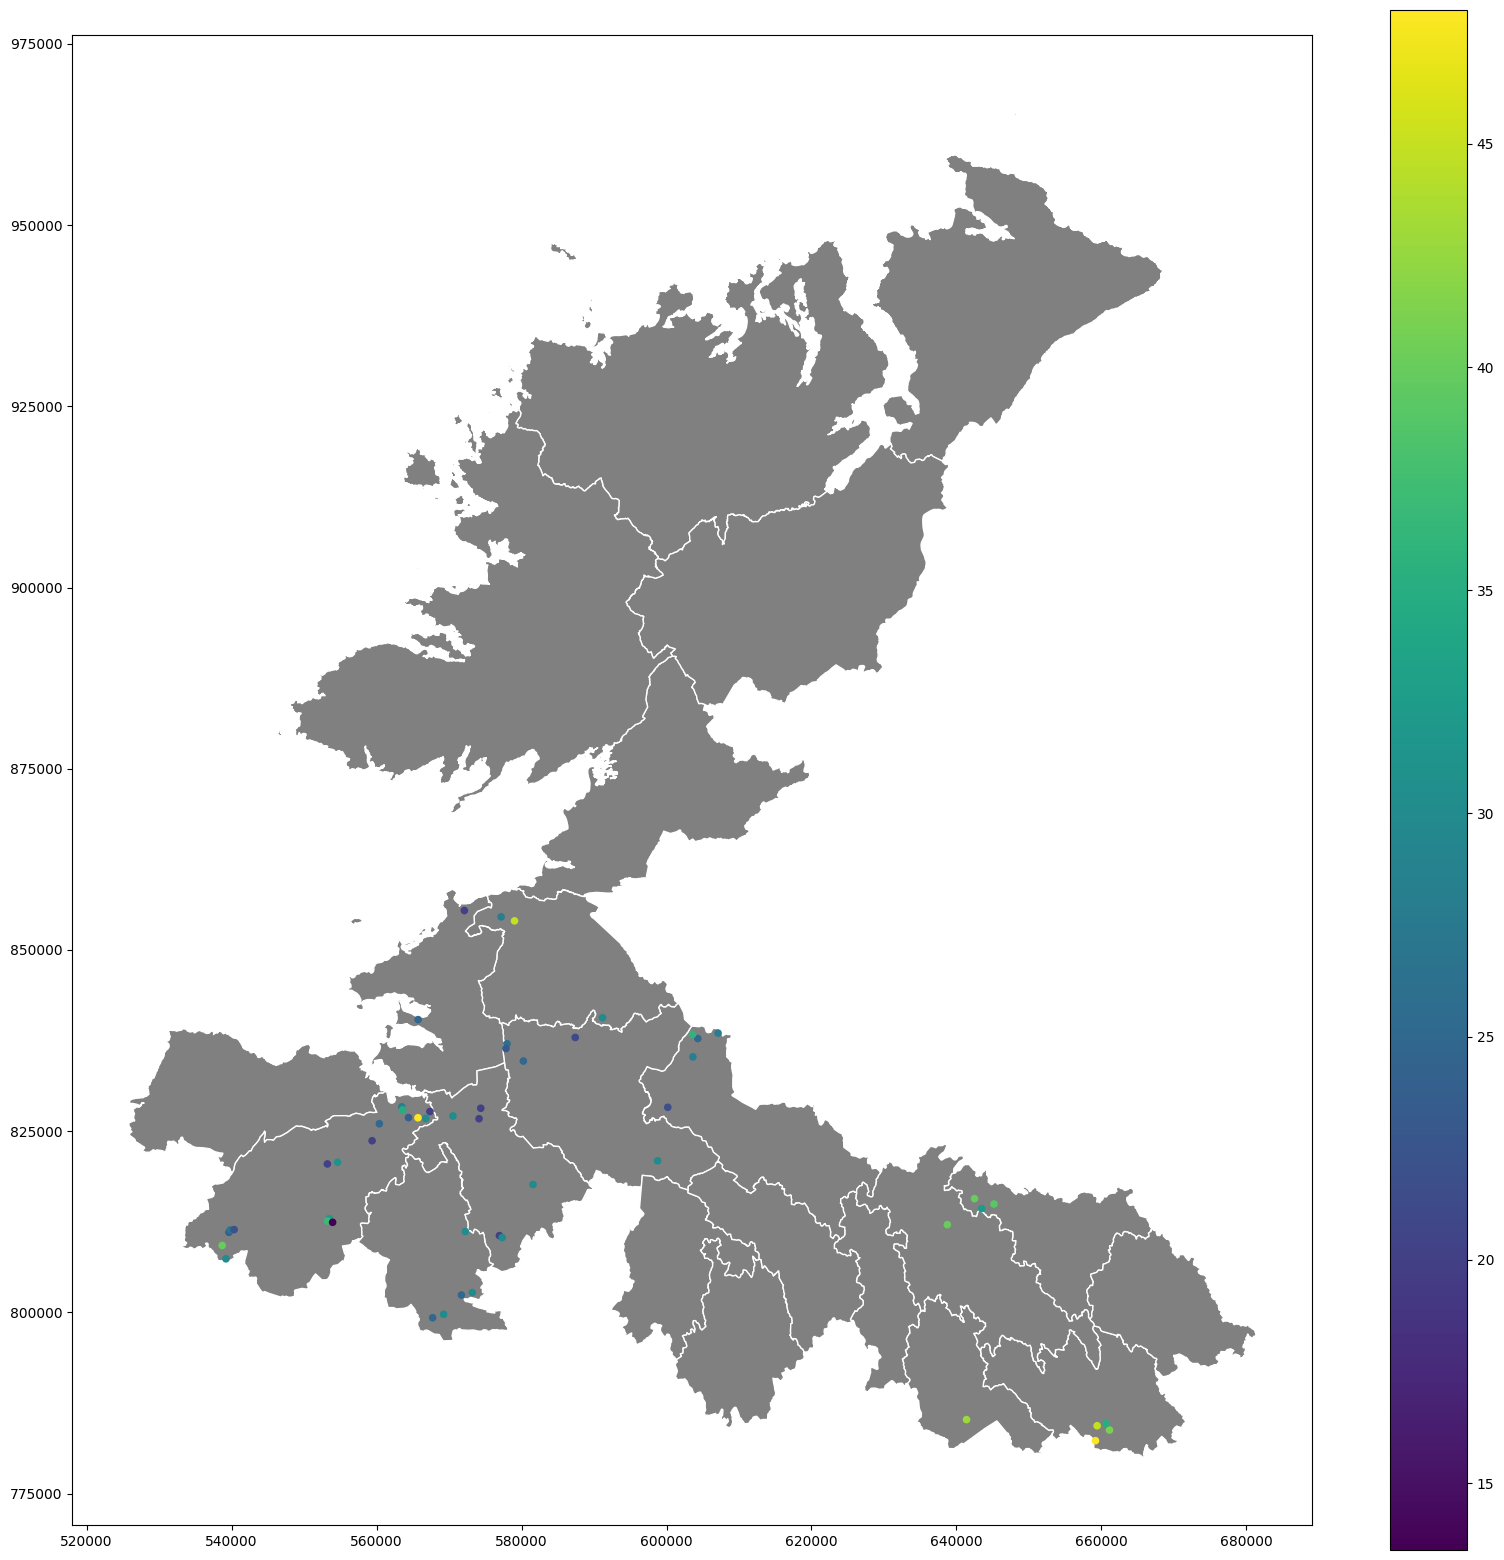

In [77]:
# Plot the Cashels with diameter information on a map by size of diameter
fig, ax = plt.subplots(figsize=(20, 20))
tuatha_nw_1600_mod.plot(ax=ax, color='grey', edgecolor='white')
cashels_with_diameter.plot(ax=ax, column='DIAMETER', legend=True, cmap='viridis', markersize=20)
plt.show()


In [ ]:
# 

ANALYSIS 

In [69]:
 

# Create a spatial weights matrix
w = weights.KNN.from_dataframe(raths_with_diameter, k=5)

# Calculate Moran's I, a measure of spatial autocorrelation
w = weights.KNN.from_dataframe(raths_with_diameter, k=5)

# Calculate Moran's I, a measure of spatial autocorrelation
moran = esda.Moran(raths_with_diameter['DIAMETER'], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


Moran's I: 0.15178737613947052, p-value: 0.001


/Users/mensab/Documents/GitHub/Artefact/artefactenv/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [78]:
# PLot the Moran's I for Cashels
w = weights.KNN.from_dataframe(cashels_with_diameter, k=5)

# Calculate Moran's I, a measure of spatial autocorrelation
moran = esda.Moran(cashels_with_diameter['DIAMETER'], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


Moran's I: 0.31192900570835225, p-value: 0.002


/Users/mensab/Documents/GitHub/Artefact/artefactenv/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ANALYSIS 

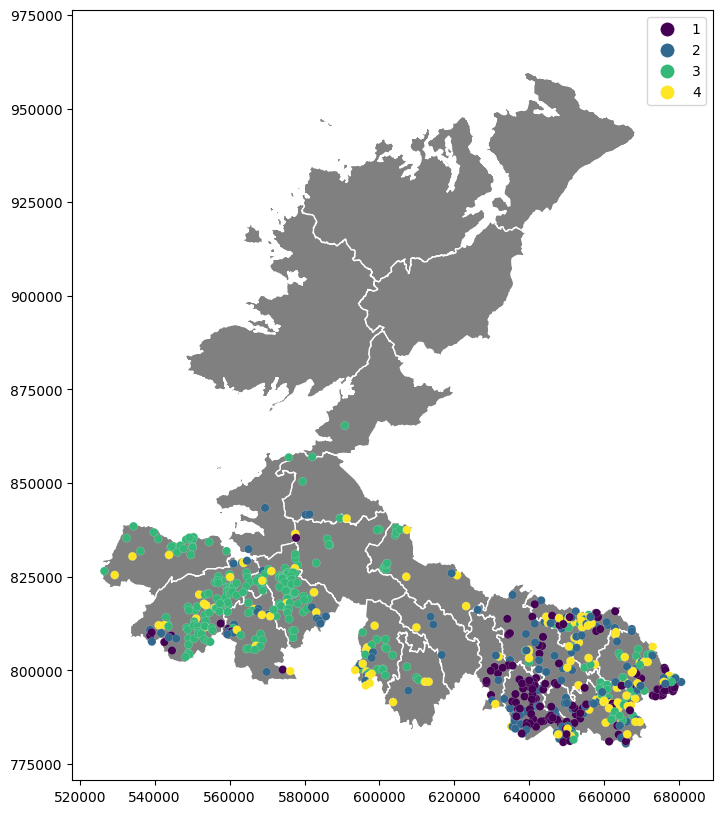

In [73]:
# Calculate local Moran's I
lisa = esda.Moran_Local(raths_with_diameter['DIAMETER'], w)

# Create a boolean mask for significant LISA values
lisa_significant = lisa.p_sim < 0.05

# Plot
fig, ax = plt.subplots(figsize=(10,10))
tuatha_nw_1600_mod.plot(ax=ax, color='grey', edgecolor='white')
raths_with_diameter.assign(cl=lisa.q).plot(column='cl', categorical=True, 
        k=2, cmap='viridis', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
        
plt.show()

In [11]:
# Search for a specific w
search_word = 'rectangular'
for word, freq in words_freq:
    if word == search_word:
        print(freq)

# Create a list of words/phrases to search for, and store it in a variable.

search_words = ['single banked','double banked','triple banked','univallate','bivallate', 'trivallate', 'rectangular', 'square', 'round', 'oval', 'octagonal', 'hexagonal', 'polygonal', 'circular', 'subrectangular', 'suboval`.`', 'subcircular', 'quadrilateral', 'width', 'length', 'diameter', 'height', 'depth', 'size', 'dimension', 'shape', 'area', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'width', 'length', 'height', 'depth', 'thickness', 'size', 'dimension', 'shape', 'area', 'volume', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'width', 'length', 'height', 'depth', 'thickness', 'size', 'dimension', 'shape', 'area', 'volume', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'width', 'length', 'height', 'depth', 'size', 'dimension', 'shape', 'area', 'volume', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'width', 'length', 'height', 'depth', 'thickness', 'size', 'dimension', 'shape', 'area', 'volume', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'width', 'length', 'height', 'depth', 'thickness', 'size', 'dimension', 'shape', 'area', 'volume', 'circumference', 'perimeter', 'diameter', 'radius', 'diagonal', 'diam', 'entrance']

# Create a dictionary to store the counts of each word/phrase
search_words_freq = {}

# Loop through each word/phrase in the list
for search_word in search_words:
    # Loop through each word/phrase in the words_freq list
    for word, freq in words_freq:
        # If the word/phrase in the words_freq list matches the search word/phrase
        if word == search_word:
            # Add the word/phrase and its count to the dictionary
            search_words_freq[search_word] = freq

# Print the dictionary
print(search_words_freq)





299
{'single banked': 5, 'double banked': 2, 'bivallate': 7, 'trivallate': 1, 'rectangular': 299, 'square': 43, 'round': 134, 'oval': 932, 'octagonal': 3, 'polygonal': 7, 'circular': 3906, 'subrectangular': 131, 'subcircular': 496, 'width': 96, 'length': 23, 'diameter': 112, 'height': 209, 'depth': 9, 'size': 14, 'dimension': 9, 'shape': 11, 'area': 4719, 'circumference': 6, 'perimeter': 191, 'radius': 2, 'thickness': 12, 'volume': 109, 'diam': 3599, 'entrance': 1082}


In [12]:
dimension_patterns = [{'LOWER': 'diam.'}, {'IS_DIGIT': True}, {'LOWER': 'm'}]
shape_patterns = [{'LOWER': 'square'}, {'LOWER': 'oval'}, {'LOWER': 'circular'}]

In [ ]:
def dimension_shape_ner(doc):
    dimension_matcher = spacy.matcher.Matcher(nlp.vocab)
    dimension_matcher.add("DIMENSION", None, dimension_patterns)

    shape_matcher = spacy.matcher.Matcher(nlp.vocab)
    shape_matcher.add("SHAPE", None, shape_patterns)

    dimension_matches = dimension_matcher(doc)
    shape_matches = shape_matcher(doc)

    for match_id, start, end in dimension_matches:
        span = Span(doc, start, end, label="DIMENSION")
        doc.ents = list(doc.ents) + [span]

    for match_id, start, end in shape_matches:
        span = Span(doc, start, end, label="SHAPE")
        doc.ents = list(doc.ents) + [span]

    return doc

# Add the custom NER component to the pipeline
nlp.add_pipe(dimension_shape_ner, last=True)



In [13]:
ef extract_entities(text):
    doc = nlp(text)
    entities = [{'text': ent.text, 'start': ent.start_char, 'end': ent.end_char, 'label': ent.label_}
                for ent in doc.ents]
    return entities


SyntaxError: invalid syntax (2153121764.py, line 1)

In [ ]:
f = pd.DataFrame({'text_column': ["diam. 8m square", "circular shape 10m"]})
df['extracted_features'] = df['text_column'].apply(extract_entities)
print(df)

In [ ]:
# Assuming `monuments` is a GeoDataFrame with your monuments data
# Extract the x and y coordinates from the geometry
points = np.array([monument.geometry.coords[0] for monument in monuments])

# Compute Voronoi tesselation
vor = Voronoi(points)

# Plot
voronoi_plot_2d(vor)
plt.show()